# StarcNet demo for NGC1566
This notebook executes a demo with **already downloaded** `.fits` and `.tabs` files saved to folders `legus/frc_fits_files` and `legus/tab_files` respectively.

## Table of contents
* [Getting started](#Getting-started)
* [Create dataset](#Create-dataset)
* [Run StarcNet](#Run-StarcNet)
    * [Load dataset](#Load-dataset)
    * [Classify objects](#Classify-objects)
* [Create text file with predictions](#Create-text-file-with-predictions)
* [Create galaxy image with predictions](#Create-galaxy-image-with-predictions)

## Getting started

In [1]:
import os
import sys
import csv
import time
import pickle
import numpy as np

import torch
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

sys.path.insert(0, './src/utils')
sys.path.insert(0, './model')
from data_utils import load_db
from starcnet import Net

Check that galaxy name and filenames are already in the `.txt` files `targets.txt`, `frc_fits_links.txt`, and `tab_links.txt`. The complete download link should be added if used with online LEGUS catalogs.

In [2]:
print(open('targets.txt', 'r').read())
print(open('frc_fits_links.txt', 'r').read())
print(open('tab_links.txt', 'r').read())

ngc1566

https://archive.stsci.edu/hlsps/legus/ngc1566/ngc1566_drc.tar.gz

https://archive.stsci.edu/hlsps/legus/ngc1566/cluster_catalogs/deterministic/hlsp_legus_hst_wfc3_ngc1566_multiband_v1_padagb-mwext-avgapcor.tab



## Create dataset
Create a 32x32x5 array per object in the catalog (`.tab` file). Each array is object centered and has the 5 bands of the photometric information from the HST.

In [3]:
print('creating dataset...')
os.system('bash create_dataset.sh')
print('dataset created')

creating dataset...
dataset created


## Run StarcNet

In [4]:
batch_size = 64 # input batch size for testing (default: 64)
data_dir = 'data/' # dataset directory
dataset = 'raw_32x32' # dataset file reference
checkpoint = 'model/starcnet.pth' # trained model
gpu = '' # CUDA visible device (when using a GPU add GPU id (e.g. '0'))
cuda = False # enables CUDA training (when using a GPU change to True)

### Load dataset

In [5]:
data_all, _, ids = load_db(os.path.join(data_dir,'test_'+dataset+'.dat'))
mean = np.load(os.path.join(data_dir,'mean.npy'))

data_test = data_all - mean[np.newaxis,:,np.newaxis,np.newaxis] # subtract mean

data = torch.from_numpy(data_test).float()
test_loader = DataLoader(TensorDataset(data), batch_size=batch_size, shuffle=False)

### Classify objects

In [6]:
def test(test_loader):
    '''
    Forward pass through the CNN for one epoch
    '''
    model.eval()
    predictions = np.array([], dtype=np.int64).reshape(0) # placeholder for all predictions
    scores = np.array([], dtype=np.float32).reshape(0,4) # placeholder for all scores
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            if cuda:
                data = Variable(data[0].cuda())
            else:
                data = Variable(data[0])
            output = model(data) # forward pass through the CNN
            pred = output.data.max(1)[1] # get the index of the max log-probability
            predictions = np.concatenate((predictions, pred.cpu().numpy()))
            scores = np.concatenate((scores, output.data.cpu().numpy()),axis=0)
    return predictions, scores


def load_weights(model):
    '''
    Load trained parameters to model
    '''
    model_dict = model.state_dict()
    if cuda:
        pretrained_dict = torch.load(checkpoint)
    else:
        pretrained_dict = torch.load(checkpoint, map_location=torch.device('cpu'))
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size() }
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

In [7]:
start_time = time.time()

cuda = cuda and torch.cuda.is_available()
os.environ["CUDA_VISIBLE_DEVICES"] = gpu

model = Net() # create model with StarcNet architecture
load_weights(model) # load trained model parameters

if cuda:
    model.cuda()

predictions, scores = test(test_loader) # classify all 32x32x5 arrays

np.save(os.path.join('output','scores'), scores) # save scores to 'output/scores.npy' file
print('End of classification | time: %.2fs'%(time.time() - start_time))
print('-'*40)
print('Objects classified as Class 1: %d'%(len(np.where(predictions == 0)[0])))
print('Objects classified as Class 2: %d'%(len(np.where(predictions == 1)[0])))
print('Objects classified as Class 3: %d'%(len(np.where(predictions == 2)[0])))
print('Objects classified as Class 4: %d'%(len(np.where(predictions == 3)[0])))

End of classification | time: 27.26s
----------------------------------------
Objects classified as Class 1: 621
Objects classified as Class 2: 197
Objects classified as Class 3: 240
Objects classified as Class 4: 1694


## Create text file with predictions

In [8]:
with open('data/test_raw_32x32.dat', 'rb') as infile:
    dset = pickle.load(infile)
data, ids, galaxies, coords = dset['data'], dset['ids'], dset['galaxies'], dset['coordinates']

scores = np.load('output/scores.npy')
preds = np.argmax(scores,axis=1)

with open('output/predictions.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(['Galaxy', 'Id', 'X', 'Y','Prediction'])
    for i in range(len(ids)):
        filewriter.writerow([galaxies[i], ids[i], coords[i][0], coords[i][1], preds[i]+1])

print("Text file with predictions: 'output/predictions.csv'")

Text file with predictions: 'output/predictions.csv'


## Create galaxy image with predictions

In [9]:
os.system('python src/run_visualization.py')

print("Image with predictions: 'output/predictions.png'")

Image with predictions: 'output/predictions.png'


## Visualize top 10 classified objects per class

In [10]:
import matplotlib.pyplot as plt
from scipy.special import softmax

def legus2rgb(im):
    datac = np.zeros((im.shape[1],im.shape[2],3), dtype=np.float64)
    datac[:,:,2] = (21.63*im[0,:,:] + 8.63*im[1,:,:]) / 2.
    datac[:,:,1] = (4.52*im[2,:,:])
    datac[:,:,0] = (1.23*im[3,:,:] + im[4,:,:]) / 2.
    return np.clip(datac, 0,1)

[Class 1] Objects: 621


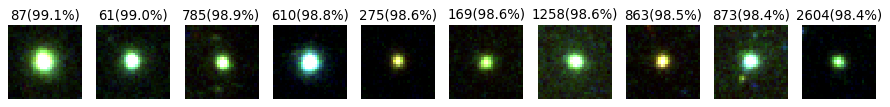

[Class 2] Objects: 197


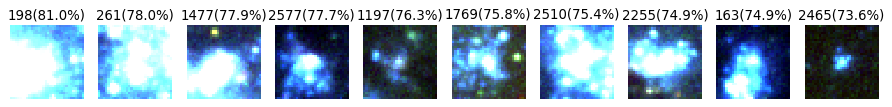

[Class 3] Objects: 240


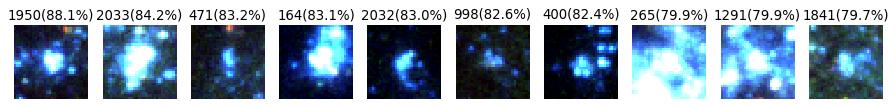

[Class 4] Objects: 1694


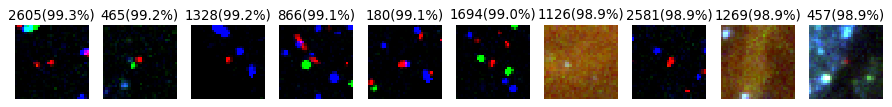

In [11]:
sz = 16 # patch size (i.e. sz x sz pixels)
num_objs = 10 # top-N objects to show

for class_label in range(4):
    class_ids = np.where(predictions == class_label)
    scores_ids = softmax(scores, axis=1)[class_ids][:,class_label]
    sorted_ids = np.argsort(scores_ids)[::-1]
    
    print('[Class %d] Objects: %d'%(class_label+1,len(sorted_ids)))
    fig = plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')
    for i in range(num_objs):
        plt.subplot(1,num_objs,i+1)
        plt.imshow(legus2rgb(data_all[class_ids][sorted_ids][i,:,:,:]))
        plt.title('%d(%.1f%%)'%(ids[class_ids[0][sorted_ids[i]]],scores_ids[sorted_ids[i]]*100))
        plt.axis('off')
    plt.show()
    
# Each image has as title the id and score [id(score)]